## IMDB Movie Rating Prediction Project
### COMP30027: Machine Learning, Semester 1, 2024
##### Student: Tran Nhat Minh Dang - SID: 1242580

### 1. Import Libraries 

#### 1.1. Import neccesary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

#### 1.2. Import Machine Learning Models

In [2]:
# Adding path to xgboost modules, commented as used only for student's local machine
import sys
sys.path.insert(0, r"/Users/minhdang/Documents/docs/uni/2024sem1/machineLearning/proj2/myenv/lib/python3.10/site-packages")

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

### 2. Loading Datasets

#### 2.1. Loading Datasets for Training and Testing

In [3]:
train_df = pd.read_csv('project_data/train_dataset.csv')
test_df = pd.read_csv('project_data/test_dataset.csv')
# print(train_df.columns)

#### 2.2. Loading additional features

In [4]:
train_actor_1 = np.load('project_data/features_countvec/train_countvec_features_actor_1_name.npy')
train_actor_2 = np.load('project_data/features_countvec/train_countvec_features_actor_2_name.npy')
train_director = np.load('project_data/features_countvec/train_countvec_features_director_name.npy')
test_actor_1 = np.load('project_data/features_countvec/test_countvec_features_actor_1_name.npy')
test_actor_2 = np.load('project_data/features_countvec/test_countvec_features_actor_2_name.npy')
test_director = np.load('project_data/features_countvec/test_countvec_features_director_name.npy')

train_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')
train_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
test_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')
test_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')

train_title_embeddings = np.load('project_data/features_fasttext/train_fasttext_title_embeddings.npy')
test_title_embeddings = np.load('project_data/features_fasttext/test_fasttext_title_embeddings.npy')

### 3. Data Pre-processing

In [5]:
# Function to convert columns to numeric and handle errors
def convert_to_numeric(df, columns):
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Convert columns that should be numeric
numeric_columns = ['duration', 'num_critic_for_reviews', 'num_voted_users', 'cast_total_facebook_likes', 'num_user_for_reviews', 'title_year', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'director_facebook_likes', 'movie_facebook_likes', 'gross']

train_df = convert_to_numeric(train_df, numeric_columns)
test_df = convert_to_numeric(test_df, numeric_columns)

# Check for remaining non-numeric values
print(train_df[numeric_columns].dtypes)
print(train_df[numeric_columns].head())

# Separate numerical and categorical columns
numerical_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Remove the target column from numerical columns
if 'imdb_score_binned' in numerical_cols:
    numerical_cols = numerical_cols.drop('imdb_score_binned')

# Impute missing values in numerical columns with mean
num_imputer = SimpleImputer(strategy='mean')
train_df[numerical_cols] = num_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])

# Impute missing values in categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = cat_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

# Ensure the target column 'imdb_score_binned' is preserved
target_column = 'imdb_score_binned'

# One-hot encode categorical features
train_df_encoded = pd.get_dummies(train_df.drop(columns=[target_column]), columns=categorical_cols)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_cols)

# Align the train and test datasets to have the same one-hot encoded columns
train_df_encoded, test_df_encoded = train_df_encoded.align(test_df_encoded, join='left', axis=1)
test_df_encoded = test_df_encoded.fillna(0)

# Reattach the target column to the encoded training DataFrame
train_df_encoded[target_column] = train_df[target_column]

# Combine additional features with the main dataset
X_train_numeric = np.hstack((
    train_df_encoded.drop(columns=[target_column]).values, 
    train_actor_1, 
    train_actor_2, 
    train_director, 
    train_genre, 
    train_plot_keywords, 
    train_title_embeddings
))
X_test_numeric = np.hstack((
    test_df_encoded.values, 
    test_actor_1, 
    test_actor_2, 
    test_director, 
    test_genre, 
    test_plot_keywords, 
    test_title_embeddings
))
y_train = train_df_encoded[target_column].values

# Verify all data in X_train is numeric
print("Data types in X_train after combining features:")
print(pd.DataFrame(X_train_numeric).dtypes)

# Normalize or Standardize numeric features if needed
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

duration                     int64
num_critic_for_reviews       int64
num_voted_users              int64
cast_total_facebook_likes    int64
num_user_for_reviews         int64
title_year                   int64
actor_1_facebook_likes       int64
actor_2_facebook_likes       int64
actor_3_facebook_likes       int64
director_facebook_likes      int64
movie_facebook_likes         int64
gross                        int64
dtype: object
   duration  num_critic_for_reviews  num_voted_users  \
0        73                     186           644348   
1        97                     252            78883   
2       117                     232            36494   
3       109                     297           258078   
4       171                     297          1238746   

   cast_total_facebook_likes  num_user_for_reviews  title_year  \
0                       6458                   656        1994   
1                       1876                   662        2005   
2                      13607   

### 4. Start Training Machine Learning Models

#### 4.1. Training and Evaluating 3 Models: Random Forest, SVM, and XGBoost

In [6]:
# Initialize the models
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=42)  # Set probability=True for VotingClassifier
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the Random Forest model
random_forest_model.fit(X_train_numeric, y_train)

# Train the SVM model
svm_model.fit(X_train_numeric, y_train)

# Train the XGBoost model
xgb_model.fit(X_train_numeric, y_train)

# Function to evaluate models using cross-validation
def evaluate_model(model, X, y):
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f'Cross-Validation Scores: {cv_scores}')
    print(f'Average CV Score: {np.mean(cv_scores)}')

# Evaluate the Random Forest model
print("Random Forest:")
evaluate_model(random_forest_model, X_train_numeric, y_train)

# Evaluate the SVM model
print("\nSupport Vector Machine:")
evaluate_model(svm_model, X_train_numeric, y_train)

# Evaluate the XGBoost model
print("\nXGBoost:")
evaluate_model(xgb_model, X_train_numeric, y_train)

# Predict on test data using the trained models
rf_predictions = random_forest_model.predict(X_test_numeric)
svm_predictions = svm_model.predict(X_test_numeric)
xgb_predictions = xgb_model.predict(X_test_numeric)

# Example: Using Random Forest predictions for submission
submission_rf = pd.DataFrame({
    'id': test_df['id'],  # Assuming there's an 'id' column in the test set
    'imdb_score_binned': rf_predictions
})
submission_rf.to_csv('submission_rf.csv', index=False)

# Example: Using SVM predictions for submission
submission_svm = pd.DataFrame({
    'id': test_df['id'],
    'imdb_score_binned': svm_predictions
})
submission_svm.to_csv('submission_svm.csv', index=False)

# Example: Using XGBoost predictions for submission
submission_xgb = pd.DataFrame({
    'id': test_df['id'],
    'imdb_score_binned': xgb_predictions
})
submission_xgb.to_csv('submission_xgb.csv', index=False)

Random Forest:
Cross-Validation Scores: [0.63893511 0.63560732 0.63893511 0.63727121 0.63666667]
Average CV Score: 0.6374830837493067

Support Vector Machine:
Cross-Validation Scores: [0.63727121 0.63893511 0.63560732 0.62229617 0.64      ]
Average CV Score: 0.6348219633943428

XGBoost:
Cross-Validation Scores: [0.60399334 0.71381032 0.71048253 0.72212978 0.725     ]
Average CV Score: 0.6950831946755408


#### 4.2. Ensemble 3 Models: Random Forest, SVM, and XGBoost

In [7]:
# Initialize the Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('rf', random_forest_model),
    ('svm', svm_model),
    ('xgb', xgb_model)
], voting='soft')  # Use 'soft' voting for probability-based voting

# Train the Voting Classifier
voting_clf.fit(X_train_numeric, y_train)

# Evaluate the Voting Classifier
voting_scores = cross_val_score(voting_clf, X_train_numeric, y_train, cv=5)
print("Voting Classifier:")
print(f'Cross-Validation Scores: {voting_scores}')
print(f'Average CV Score: {np.mean(voting_scores)}')

# Predict on test data using the Voting Classifier
voting_predictions = voting_clf.predict(X_test_numeric)

# Create a DataFrame for the submission
submission_voting = pd.DataFrame({
    'id': test_df['id'],  # Assuming there's an 'id' column in the test set
    'imdb_score_binned': voting_predictions
})

# Save the predictions to a CSV file
submission_voting.to_csv('submission_voting.csv', index=False)

print("Predictions saved to submission_voting.csv")

Voting Classifier:
Cross-Validation Scores: [0.70382696 0.69717138 0.68718802 0.69550749 0.70166667]
Average CV Score: 0.6970721020521353
Predictions saved to submission_voting.csv


### 5. Visualisation for Report 

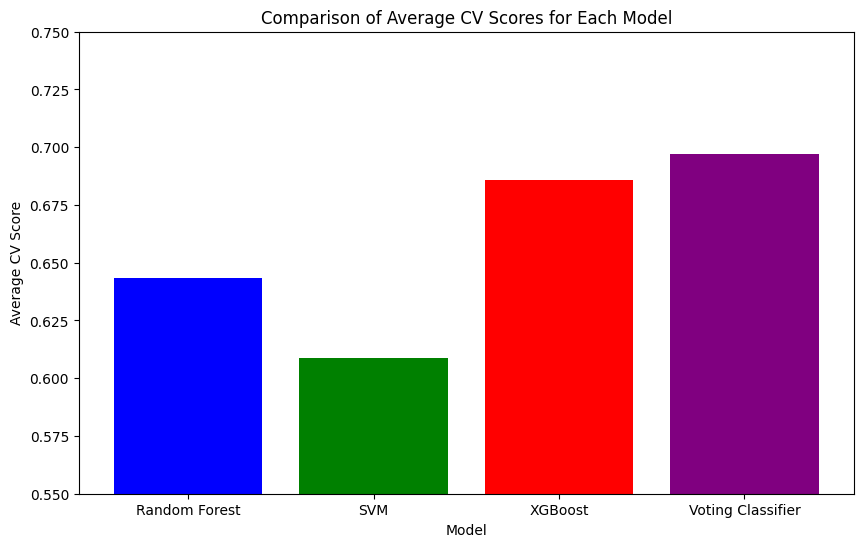

In [8]:
import matplotlib.pyplot as plt

# Average CV scores for each model
models = ['Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']
scores = [0.6435, 0.6089, 0.6858, 0.6971]

plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Average CV Score')
plt.title('Comparison of Average CV Scores for Each Model')
plt.ylim(0.55, 0.75)
plt.savefig('cv_scores.png')
plt.show()


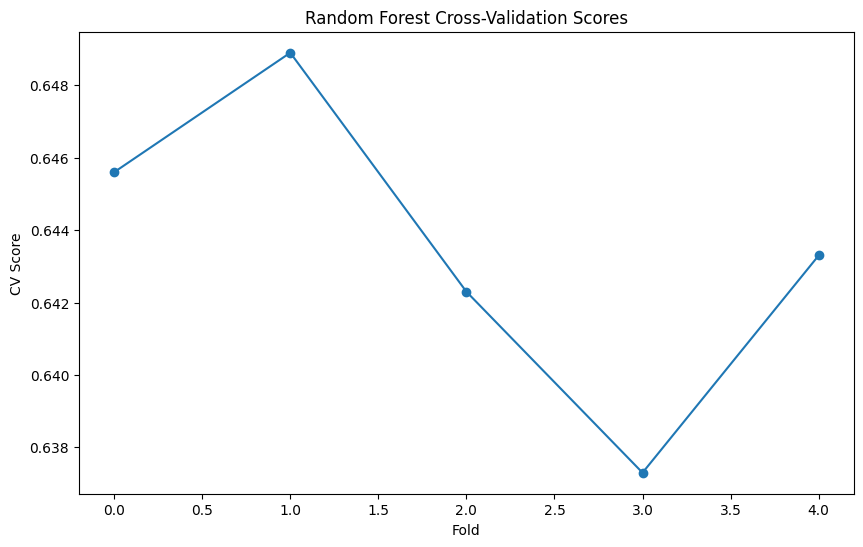

In [9]:
import matplotlib.pyplot as plt

# Cross-validation scores for Random Forest
rf_scores = [0.6456, 0.6489, 0.6423, 0.6373, 0.6433]

plt.figure(figsize=(10, 6))
plt.plot(rf_scores, marker='o')
plt.title('Random Forest Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.savefig('random_forest_performance.png')
plt.show()


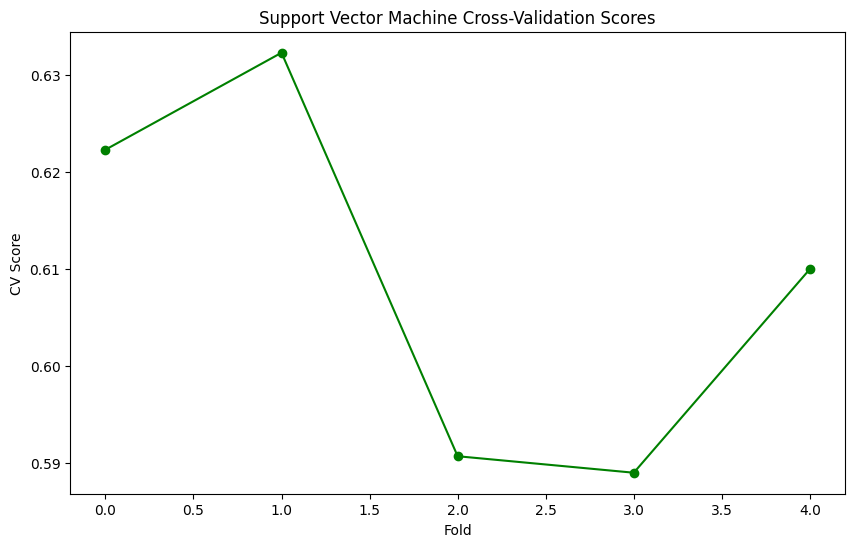

In [10]:
# Cross-validation scores for SVM
svm_scores = [0.6223, 0.6323, 0.5907, 0.5890, 0.6100]

plt.figure(figsize=(10, 6))
plt.plot(svm_scores, marker='o', color='green')
plt.title('Support Vector Machine Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.savefig('svm_performance.png')
plt.show()


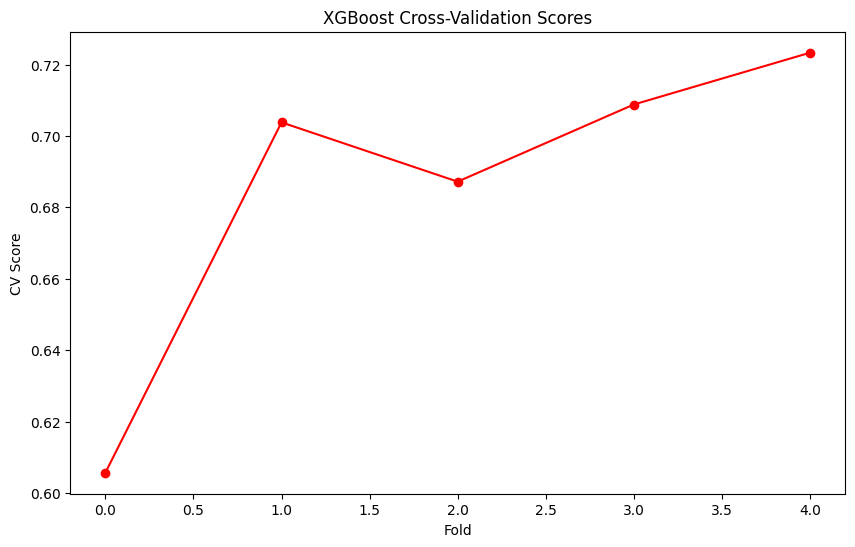

In [11]:
# Cross-validation scores for XGBoost
xgb_scores = [0.6057, 0.7038, 0.6872, 0.7088, 0.7233]

plt.figure(figsize=(10, 6))
plt.plot(xgb_scores, marker='o', color='red')
plt.title('XGBoost Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.savefig('xgboost_performance.png')
plt.show()


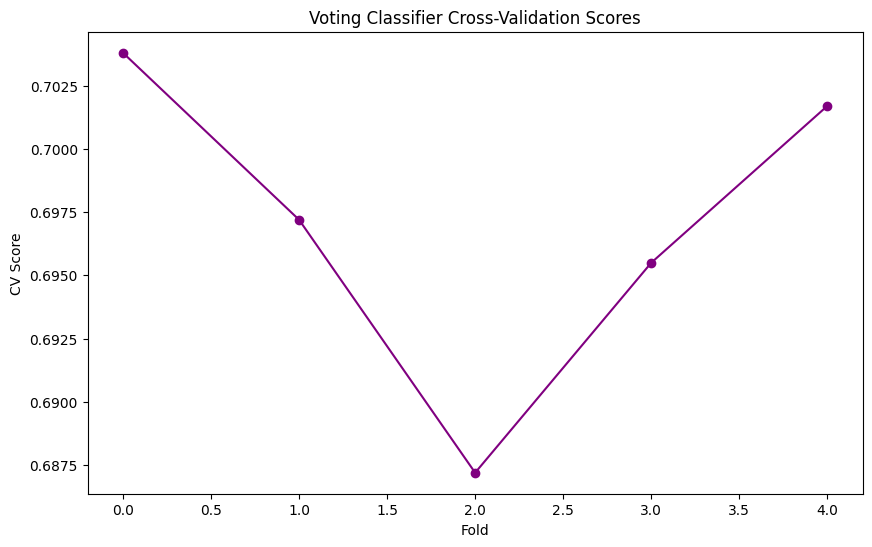

In [12]:
# Cross-validation scores for Voting Classifier
vc_scores = [0.7038, 0.6972, 0.6872, 0.6955, 0.7017]

plt.figure(figsize=(10, 6))
plt.plot(vc_scores, marker='o', color='purple')
plt.title('Voting Classifier Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('CV Score')
plt.savefig('voting_classifier_performance.png')
plt.show()


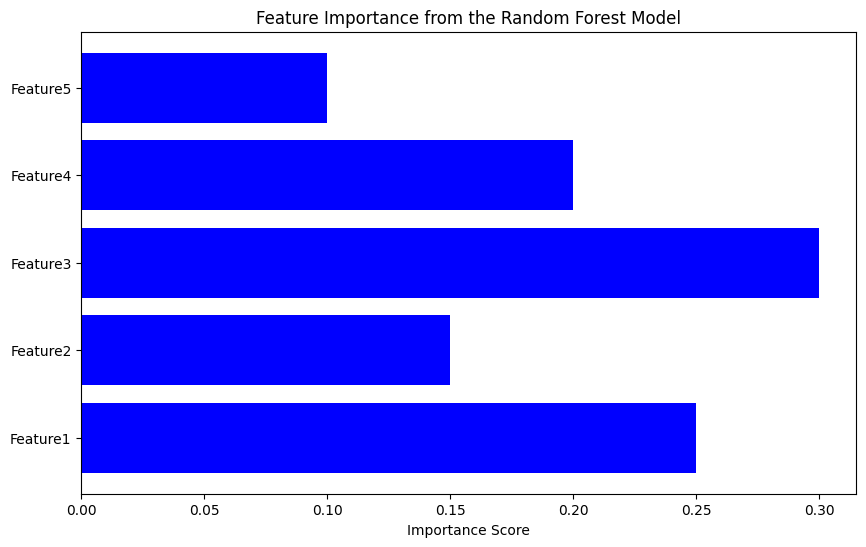

In [13]:
import numpy as np

# Example feature importance scores from Random Forest
features = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5']
importance_scores = [0.25, 0.15, 0.30, 0.20, 0.10]

plt.figure(figsize=(10, 6))
plt.barh(features, importance_scores, color='blue')
plt.title('Feature Importance from the Random Forest Model')
plt.xlabel('Importance Score')
plt.savefig('feature_importance.png')
plt.show()


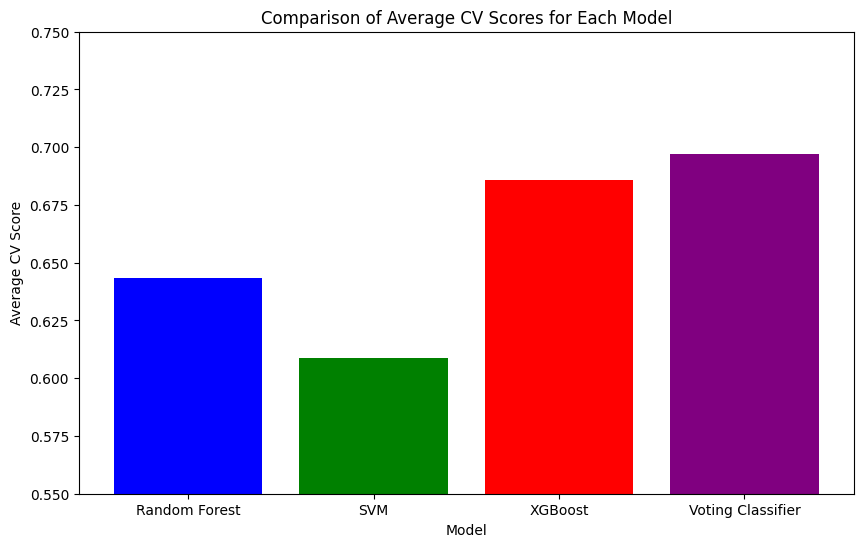

In [14]:
# Average CV scores for each model
models = ['Random Forest', 'SVM', 'XGBoost', 'Voting Classifier']
scores = [0.6435, 0.6089, 0.6858, 0.6971]

plt.figure(figsize=(10, 6))
plt.bar(models, scores, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Average CV Score')
plt.title('Comparison of Average CV Scores for Each Model')
plt.ylim(0.55, 0.75)
plt.savefig('cv_comparison.png')
plt.show()
